In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit,mnlogit
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("forecasting_case_study.csv")
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Product             1218 non-null   object 
 1   date                1218 non-null   object 
 2   Sales               1218 non-null   int64  
 3   Price Discount (%)  1218 non-null   object 
 4   In-Store Promo      1218 non-null   int64  
 5   Catalogue Promo     1218 non-null   int64  
 6   Store End Promo     1218 non-null   int64  
 7   Google_Mobility     1218 non-null   float64
 8   Covid_Flag          1218 non-null   int64  
 9   V_DAY               1218 non-null   int64  
 10  EASTER              1218 non-null   int64  
 11  CHRISTMAS           1218 non-null   int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 114.3+ KB


In [4]:
def date_clean(df):
    df["date"] =  pd.to_datetime(df["date"])
    df['month'] = df["date"].apply(lambda t: t.month)
    df['day_week'] = df["date"].apply(lambda x: x.weekday()+1)
    df["discount"] = df["Price Discount (%)"].str.rstrip('%').astype(int)/100
    return df

In [5]:
df = date_clean(df)

In [6]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,27750,0%,0,0,0,0.0,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,29023,0%,1,0,1,0.0,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,45630,17%,0,0,0,0.0,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,26789,0%,1,0,1,0.0,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,41999,17%,0,0,0,0.0,0,0,0,0,3,7,0.17


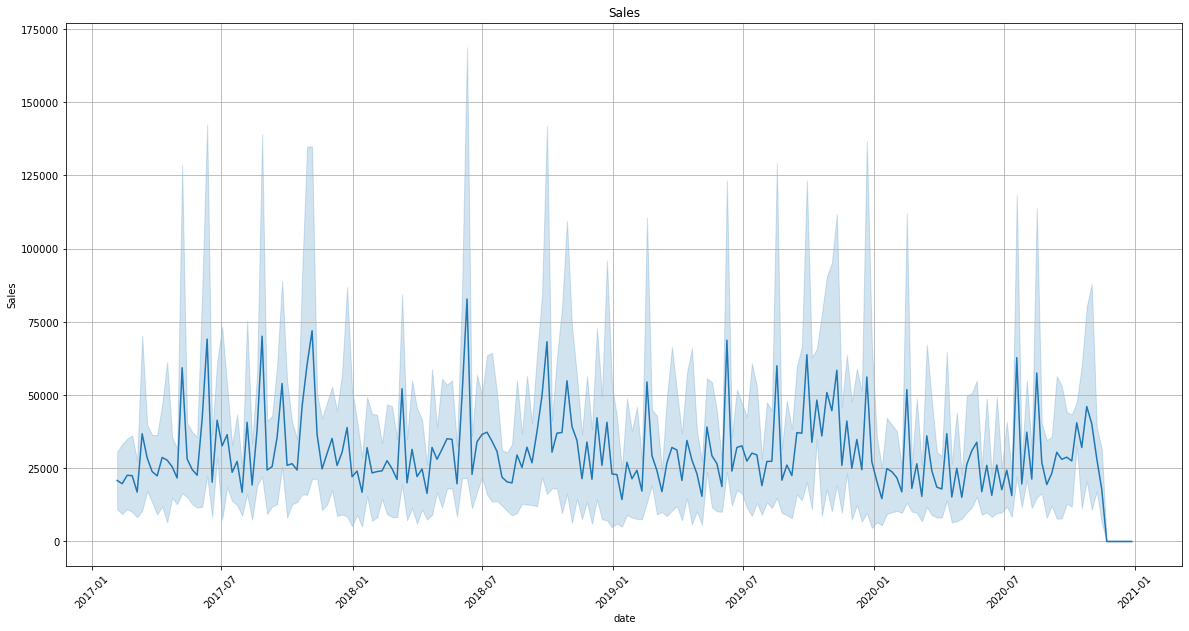

In [7]:
plt.figure(figsize = (20,10))
plt.grid()
g=sns.lineplot(x="date",y="Sales",data=df)
g.set_title('Sales')
plt.xticks(rotation=45)
plt.show()

In [8]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

In [9]:
df1 = df1[df1['Sales'] != 0]
df2 = df2[df2['Sales'] != 0]
df3 = df3[df3['Sales'] != 0]

In [10]:
# remove outliers by 90% cap
ninetieth_percentile = np.percentile(df1["Sales"], 90)
df1.loc[df["Sales"] >= ninetieth_percentile, "Sales"] = ninetieth_percentile

In [11]:
# normalization
def normalize(column):
    up = column.max()
    lo = column.min()
    y = (column - lo)/(up-lo)
    return y

df2['Sales'] = normalize(df2['Sales'])

In [12]:
# taking log
df3['Sales'] = [np.log(x) for x in df3['Sales']]

In [14]:
df1.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,27750.0,0%,0,0,0,0.0,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,29023.0,0%,1,0,1,0.0,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,45630.0,17%,0,0,0,0.0,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,26789.0,0%,1,0,1,0.0,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,41999.0,17%,0,0,0,0.0,0,0,0,0,3,7,0.17


In [15]:
df2.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,0.091669,0%,0,0,0,0.0,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,0.096107,0%,1,0,1,0.0,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,0.153997,17%,0,0,0,0.0,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,0.088319,0%,1,0,1,0.0,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,0.141340,17%,0,0,0,0.0,0,0,0,0,3,7,0.17


In [16]:
df3.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,10.230991,0%,0,0,0,0.0,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,10.275844,0%,1,0,1,0.0,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,10.728321,17%,0,0,0,0.0,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,10.195747,0%,1,0,1,0.0,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,10.645401,17%,0,0,0,0.0,0,0,0,0,3,7,0.17


In [17]:
df1.reset_index(drop=True)
df2.reset_index(drop=True)
df3.reset_index(drop=True)

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS,month,day_week,discount
0,SKU1,2017-02-05,10.230991,0%,0,0,0,0.00,0,0,0,0,2,7,0.00
1,SKU1,2017-02-12,10.275844,0%,1,0,1,0.00,0,1,0,0,2,7,0.00
2,SKU1,2017-02-19,10.728321,17%,0,0,0,0.00,0,0,0,0,2,7,0.17
3,SKU1,2017-02-26,10.195747,0%,1,0,1,0.00,0,0,0,0,2,7,0.00
4,SKU1,2017-03-05,10.645401,17%,0,0,0,0.00,0,0,0,0,3,7,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,SKU6,2020-10-18,11.478531,54%,0,1,0,-7.56,1,0,0,0,10,7,0.54
1184,SKU6,2020-10-25,11.659603,52%,0,1,0,-8.39,1,0,0,0,10,7,0.52
1185,SKU6,2020-11-01,11.932859,54%,1,0,1,-7.43,1,0,0,0,11,7,0.54
1186,SKU6,2020-11-08,10.182822,44%,1,0,1,-5.95,1,0,0,0,11,7,0.44


In [18]:
sku1 = df1[df1['Product'] == 'SKU1']
sku2 = df1[df1['Product'] == 'SKU2']
sku3 = df1[df1['Product'] == 'SKU3']
sku4 = df1[df1['Product'] == 'SKU4']
sku5 = df1[df1['Product'] == 'SKU5']
sku6 = df1[df1['Product'] == 'SKU6']

sku12 = df2[df2['Product'] == 'SKU1']
sku22 = df2[df2['Product'] == 'SKU2']
sku32 = df2[df2['Product'] == 'SKU3']
sku42 = df2[df2['Product'] == 'SKU4']
sku52 = df2[df2['Product'] == 'SKU5']
sku62 = df2[df2['Product'] == 'SKU6']

sku13 = df3[df3['Product'] == 'SKU1']
sku23 = df3[df3['Product'] == 'SKU2']
sku33 = df3[df3['Product'] == 'SKU3']
sku43 = df3[df3['Product'] == 'SKU4']
sku53 = df3[df3['Product'] == 'SKU5']
sku63 = df3[df3['Product'] == 'SKU6']

### Simple Naive (Using the last data point in the training set as prediction)

In [35]:
def naive(df):
    train_len = round(len(df) * 0.8)
    train = df[0:train_len] 
    test = df[train_len:]
    
    y_hat_naive = test.copy()
    y_hat_naive['naive_forecast'] = train['Sales'].iloc[train_len-1]
       
    mape = np.round(np.mean(np.abs(test['Sales']-y_hat_naive['naive_forecast'])/test['Sales']),2)
    accuracy = 1 - mape
    
    return accuracy

In [67]:
def best_accuracy(data1,data2,data3):
    l = list([naive(data1), naive(data2),naive(data3)])
    accuracy = max(l)
    
    d = pd.DataFrame()
    if accuracy == l[0]:
        d = data1.copy()
        method = '90% Cap'
    elif accuracy == l[1]:
        d = data2.copy()
        method = 'Normalization'
    else:
        d = data3.copy()
        method = 'Log Transformation'
    
    
    train_len = round(len(d) * 0.8)
    train = d[0:train_len] 
    test = d[train_len:]
    
    y_hat_naive = test.copy()
    y_hat_naive['naive_forecast'] = train['Sales'].iloc[train_len-1]
    
    plt.figure(figsize = (20,5))
    plt.grid()
    sns.lineplot(x="date",y="Sales",data=train,label='Train')
    sns.lineplot(x="date",y="Sales",data=test,label='Test')
    sns.lineplot(x="date",y="naive_forecast",data=y_hat_naive,label='Naive forecast')
    plt.xticks(rotation=45)
    
    rmse = np.sqrt(mean_squared_error(test['Sales'], y_hat_naive['naive_forecast'])).round(2)
    mape = 1 - accuracy
    results = pd.DataFrame({'Method':['Naive method' + ' ' + method], 'MAPE': [mape], 'RMSE': [rmse],'Accuracy':[accuracy]})
    results = results[['Method', 'RMSE', 'MAPE','Accuracy']]
    results
    
    return results

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.44,0.03,0.97


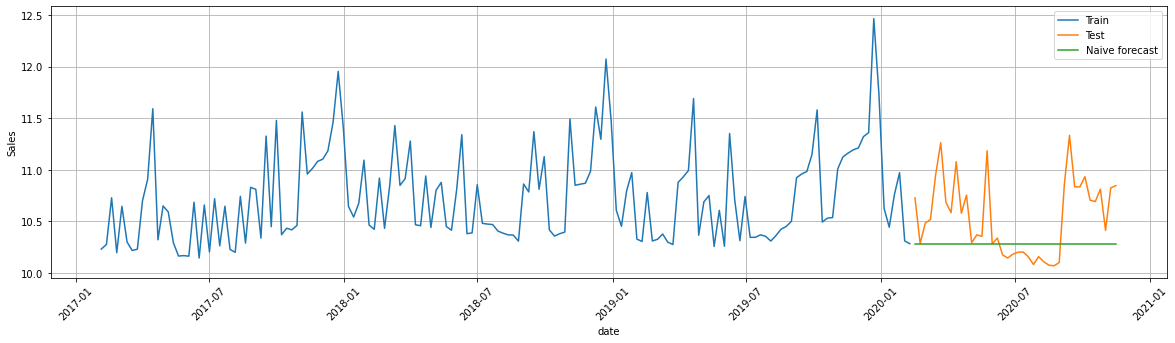

In [68]:
best_accuracy(sku1,sku12,sku13)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.75,0.08,0.92


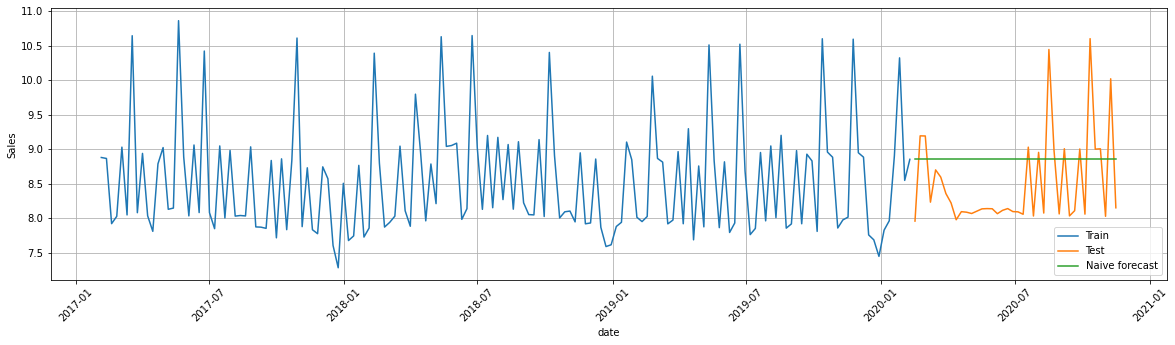

In [69]:
best_accuracy(sku2,sku22,sku23)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,1.23,0.09,0.91


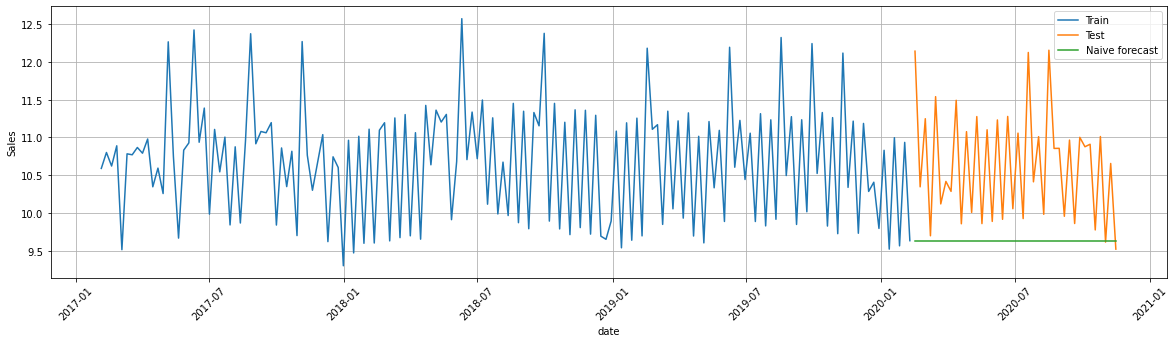

In [70]:
best_accuracy(sku3,sku32,sku33)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,1.46,0.12,0.88


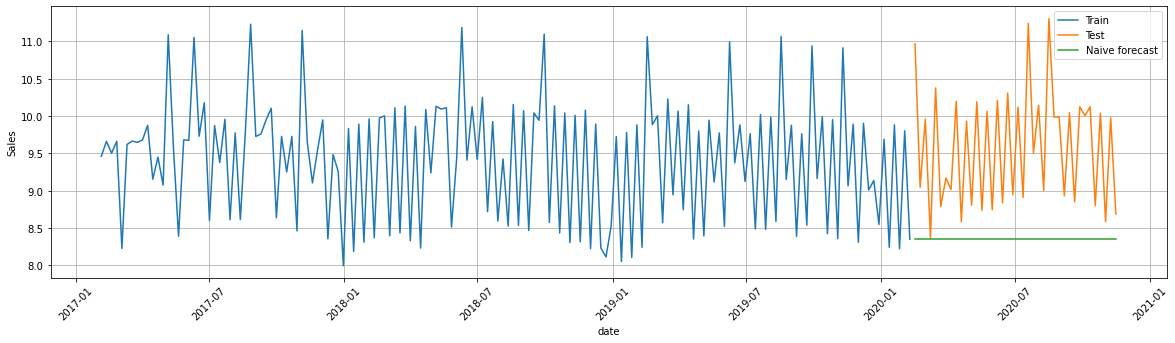

In [71]:
best_accuracy(sku4,sku42,sku43)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.71,0.06,0.94


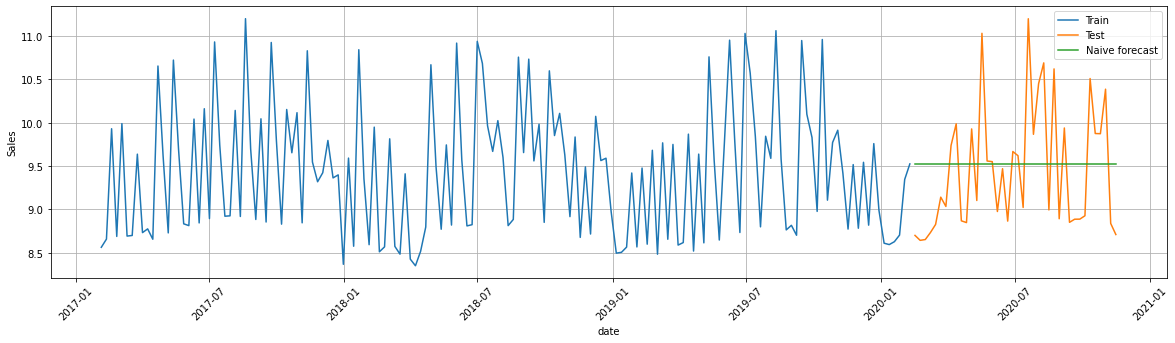

In [72]:
best_accuracy(sku5,sku52,sku53)

,Method,RMSE,MAPE,Accuracy
0,Naive method Log Transformation,0.92,0.08,0.92


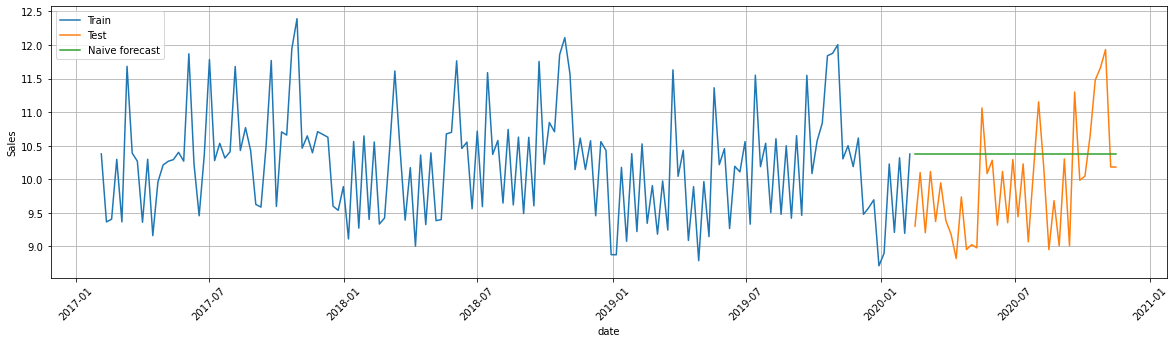

In [73]:
best_accuracy(sku6,sku62,sku63)